# C$_{l}$ : 2D Angular Power Spectrum

## test the routine for Wmap data 
Please look at https://healpy.readthedocs.io/en/latest/tutorial.html or http://www.astroml.org/examples/datasets/plot_wmap_power_spectra.html for a comparison of the final result. We compute the 2D angular power spectrum for WMap 7yr data, with applying a 0.4 deg Gaussian kernel smoothing, and compare it with `PolSpice`.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import healpy as hp                # import healpy after matplotlib!
import numpy as np
import sys
import os
home = os.getenv('HOME')
sys.path.append(home + '/github/DESILSS')
from cl import compute_cl
plt.rc('font', family='serif', size=15)

get the mask from https://lambda.gsfc.nasa.gov/product/map/dr4/masks_get.cfm                         
get the i-band map from https://lambda.gsfc.nasa.gov/product/map/dr4/maps_band_r9_i_7yr_get.cfm

In [2]:
!du -h {home}/github/DESILSS/tests/wmapdata/*v4.fits

25M	/global/homes/m/mehdi/github/DESILSS/tests/wmapdata/wmap_band_imap_r9_7yr_W_v4.fits
24M	/global/homes/m/mehdi/github/DESILSS/tests/wmapdata/wmap_temperature_analysis_mask_r9_7yr_v4.fits


/global/homes/m/mehdi/cori-envs/py3p6/lib/python3.6/site-packages/healpy/fitsfunc.py:326: UserWarning: No INDXSCHM keyword in header file : assume IMPLICIT
  "assume {}".format(schm))


Sigma is 10.191561 arcmin (0.002965 rad) 
-> fwhm is 23.999292 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin


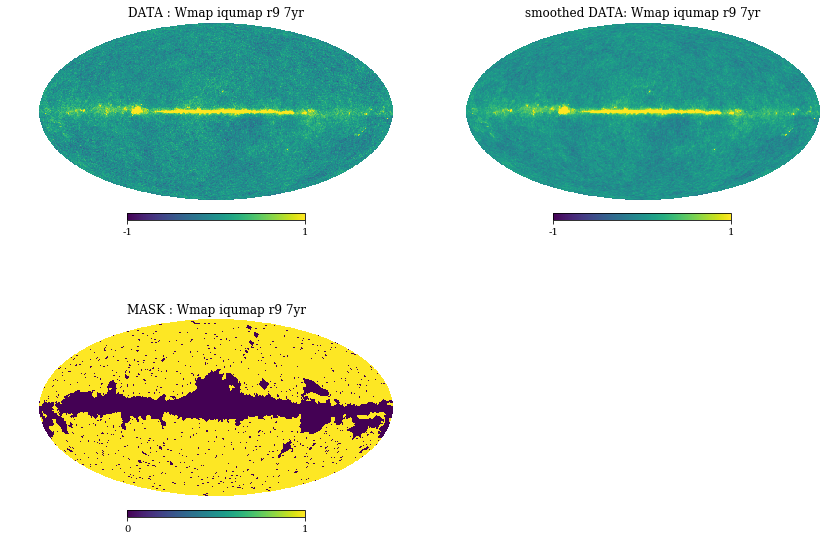

! ---- computing cl ------ 
generated the leg gauss points ... 
computed the map cl .... 
computed the weight cl .... 
correct for the "mask" (xi_map / xi_weight) .... 
Finished C_l in 13.17 [sec]
! ---- computing cl ------ 
generated the leg gauss points ... 
computed the map cl .... 
computed the weight cl .... 
correct for the "mask" (xi_map / xi_weight) .... 
Finished C_l in 13.63 [sec]


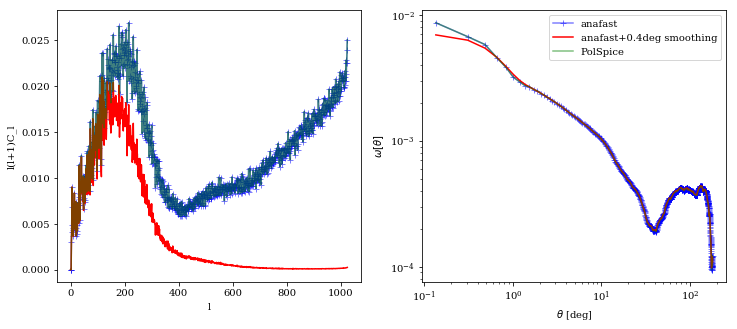

In [3]:
label = 'Wmap iqumap r9 7yr'
# path  = '/Users/rezaie/github/DESILSS/tests/wmapdata/'
path  = home + '/github/DESILSS/tests/wmapdata/'
kw    = dict(verbose=False, nest=False) # maps should be in RING format

# read maps
map1  = hp.read_map(path + 'wmap_band_imap_r9_7yr_W_v4.fits', **kw)
mask1 = hp.read_map(path + 'wmap_temperature_analysis_mask_r9_7yr_v4.fits', **kw).astype('bool') # Boolean
map1s = hp.smoothing(map1, fwhm=0.4*3.1415/180) # 0.4 deg smoothing

# plot the map and the mask
plt.figure(figsize=(14, 10))
plt.subplot(221)
hp.mollview(map1,  title='DATA : '+label, hold=True, min=-1, max=1)
plt.subplot(222)
hp.mollview(map1s,  title='smoothed DATA: '+label, hold=True, min=-1, max=1)
plt.subplot(223)
hp.mollview(mask1, title='MASK : '+label, hold=True)
plt.show()

#
# compute C_l and auto-correlations using ANAFAST
#
wmapcl     = compute_cl(map1, mask1.astype('f4'), mask1, lmax=1024) # no weight map
wmapscl    = compute_cl(map1s, mask1.astype('f4'), mask1, lmax=1024) # no weight map
ell,cell   = wmapcl['cl']
ells,cells = wmapscl['cl']
ts, xis    = wmapscl['xi']
t, xi      = wmapcl['xi']

#
# RUN POLSPICE and READ the RESULTS
#
''' 
PolSpice is run with
1. export HEALPIXDATA=$HOME/pkgs/healpix-autotools-3.31.4/data`                                
2. ~/PolSpice_v03-01-06/src/spice \
 -mapfile wmapdata/wmap_band_imap_r9_7yr_W_v4.fits
 -weightfile wmapdata/wmap_temperature_analysis_mask_r9_7yr_v4.fits 
 -maskfile wmapdata/wmap_temperature_analysis_mask_r9_7yr_v4.fits 
 -clfile wmapdata/polspice.cl -corfile wmapdata/polspice.cor 
 -nlmax 1024
'''
lp, clp    = np.loadtxt(path + 'polspice.cl', unpack=True)
tp, xip   = np.loadtxt(path + 'polspice.cor', usecols=(0, 2), unpack=True) ## let's read the PolSpice Xi
tp = np.degrees(tp)


#
# PLOT
#
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 5))
# cl
ax1.plot(ell, ell*(ell+1)*cell, color='b', alpha=0.5, marker='+', label='anafast')
ax1.plot(ell, ell*(ell+1)*cells, color='r', label='anafast+smoothing')
ax1.plot(lp, lp*(lp+1)*clp, color='g', alpha=0.5, label='PolSpice')
ax1.set_xlabel('l')
ax1.set_ylabel('l(l+1)C_l')
# ax1.legend()

# auto-correlation
ax2.plot(t, xi, color='b', alpha=0.5, marker='+', label='anafast')
ax2.plot(ts, xis, color='r', label='anafast+0.4deg smoothing')
ax2.plot(tp, xip,  color='g', alpha=0.5, label='PolSpice')
ax2.set_xlabel(r'$\theta$ [deg]')
ax2.set_ylabel(r'$\omega [\theta]$')
ax2.legend()
ax2.set_xscale('log')
ax2.set_yscale('log')
plt.show()

# LSS Mock data: $C_{l}$ and $\omega [\theta]$
## Mocks based on EBOSS ELGs
Here we test how our pipeline works on LSS data

In [1]:
%matplotlib inline
import sys
import os
home = os.getenv('HOME')
sys.path.append(home + '/github/DESILSS')

from xi import XI
from cl import compute_cl, cl2xi
import matplotlib.pyplot as plt
import healpy as hp                # import healpy after matplotlib!
import numpy as np

from tools import makedelta
plt.rc('font', family='serif', size=15)

In [2]:
!du -h {home}/github/DESILSS/tests/lssdata/*

1.3M	/global/homes/m/mehdi/github/DESILSS/tests/lssdata/3dbox_nmesh1024_L5274.0_bias1.5_seed1hp256.fits
1.2M	/global/homes/m/mehdi/github/DESILSS/tests/lssdata/3dbox_nmesh1024_L5274.0_bias1.5_seed1hp256_delta.fits
80K	/global/homes/m/mehdi/github/DESILSS/tests/lssdata/fftlog.out
1.3M	/global/homes/m/mehdi/github/DESILSS/tests/lssdata/mock.fracNgalhpmap.fits
1.2M	/global/homes/m/mehdi/github/DESILSS/tests/lssdata/mock.hpmask.fits
16K	/global/homes/m/mehdi/github/DESILSS/tests/lssdata/polspice.cl
40K	/global/homes/m/mehdi/github/DESILSS/tests/lssdata/polspice.cor
6.9M	/global/homes/m/mehdi/github/DESILSS/tests/lssdata/theta_phi_delta_weight_seed1.txt
4.0K	/global/homes/m/mehdi/github/DESILSS/tests/lssdata/theta_phi_delta_weight_seed1_2pc_new.txt
4.0K	/global/homes/m/mehdi/github/DESILSS/tests/lssdata/theta_phi_delta_weight_seed1_2pc_old.txt
2.6M	/global/homes/m/mehdi/github/DESILSS/tests/lssdata/xi_mehdiJul27
2.7M	/global/homes/m/mehdi/github/DESILSS/tests/lssdata/xi_mehdiJul27.tar


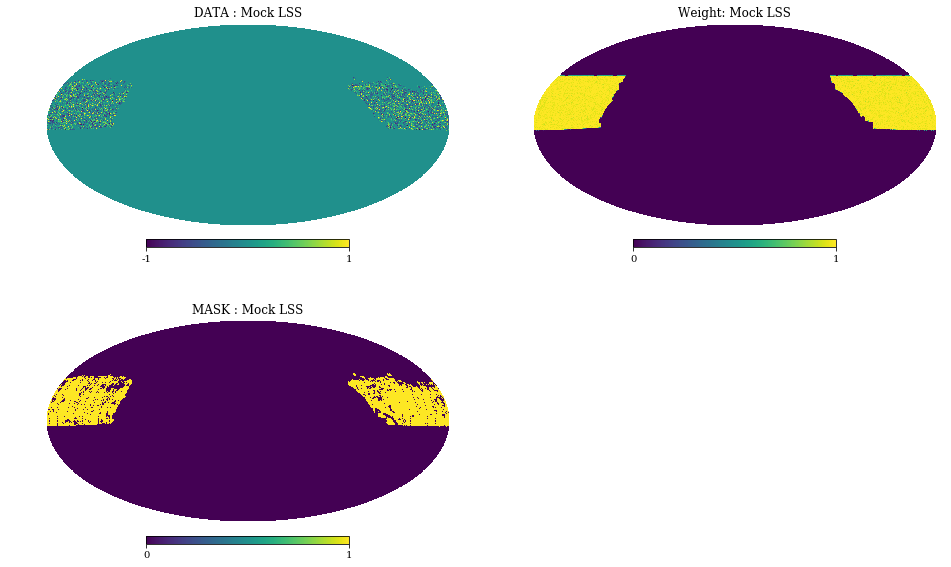

! ---- computing cl ------ 
generated the leg gauss points ... 
computed the map cl .... 
computed the weight cl .... 
correct for the "mask" (xi_map / xi_weight) .... 
Finished C_l in 2.81 [sec]
Finished hp Xi(theta) in 5.62 secs


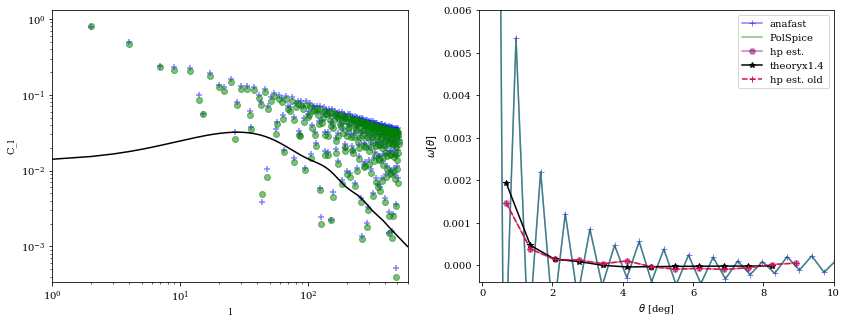

In [3]:
label = 'Mock LSS'
path  = home + '/github/DESILSS/tests/lssdata/'
# path  = '/Users/rezaie/github/DESILSS/tests/lssdata/'
kw    = dict(verbose=False, nest=False) # maps should be in RING format

# read galaxy, weight maps and the mask
galmap = hp.read_map(path + '3dbox_nmesh1024_L5274.0_bias1.5_seed1hp256.fits', **kw)
weight = hp.read_map(path + 'mock.fracNgalhpmap.fits', **kw)
mask   = hp.read_map(path + 'mock.hpmask.fits', **kw).astype('bool')

# make deltas
delta  = makedelta(galmap, weight, np.ones_like(weight), mask) # pass ones_like as selection funct.
# save delta for PolSpice
#hp.write_map(path + '3dbox_nmesh1024_L5274.0_bias1.5_seed1hp256_delta.fits', delta, overwrite=True, dtype='float64')

#
# plot the map and the mask
plt.figure(figsize=(16, 10))
plt.subplot(221)
hp.mollview(delta,  title='DATA : '+label, hold=True, min=-1, max=1)
plt.subplot(222)
hp.mollview(weight, title='Weight: '+label, hold=True, min=0, max=1)
plt.subplot(223)
hp.mollview(mask, title='MASK : '+label, hold=True)
plt.show()


# compute C_l and auto-correlations
#
lsscl = compute_cl(delta, weight, mask, lmax=512) # 

# do the paircount with the healpix based estimator
# np.degrees(hp.nside2resol(256))*3  = 0.687097
#
hpix = np.argwhere(mask).flatten()
theta, phi = hp.pix2ang(256, hpix)
bins = np.deg2rad(np.arange(0.687097, 10, 0.687097))[::-1]
xi_hp = XI(theta, phi, theta, phi, delta[mask], delta[mask], weight[mask], weight[mask], bins, 1)
#np.savetxt('lssdata/theta_phi_delta_weight_seed1.txt', np.array([theta, phi, delta[mask], weight[mask]]).T)


# run PolSpice with 
'''
module load desiconda
load_healpix
srun -n 1 -c 24 -q debug -t 01:00 ~/PolSpice_v03-01-06/src/spice 
-mapfile lssdata/3dbox_nmesh1024_L5274.0_bias1.5_seed1hp256_delta.fits -weightfile lssdata/mock.fracNgalhpmap.fits 
-maskfile lssdata/mock.hpmask.fits -corfile lssdata/polspice.cor -clfile lssdata/polspice.cl -nlmax 512

'''


# ANAFAST
ell_ana, cell_ana = lsscl['cl']
t_ana, xi_ana    = lsscl['xi']

# POLSPICE
l_pol, cl_pol  = np.loadtxt(path + 'polspice.cl', unpack=True)
t_pol, xi_pol  = np.loadtxt(path + 'polspice.cor', usecols=(0, 2), unpack=True) ## let's read the PolSpice Xi
t_pol = np.degrees(t_pol)


# theory input
# theory 
# run the old paircount (with arccos binning in run_xi_old)
t_old, xi_old = np.loadtxt(path + 'theta_phi_delta_weight_seed1_2pc_old.txt').T
l_th, cl_th   = np.loadtxt(path  + '/fftlog.out', 
                         usecols=(0,1), unpack=True)
l_th    = l_th.astype('int')
Cell_th = np.zeros(np.max(l_th)+1)
Cell_th[l_th] = cl_th
cost  = np.cos(np.deg2rad(t_old[:-1]))
t_th  = np.rad2deg(np.arccos(cost))
xi_th = cl2xi(Cell_th, cost)



#
# PLOTTING
#
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(14, 5))
# cl
ax1.scatter(ell_ana, cell_ana, color='b', alpha=0.5, marker='+', label='anafast')
ax1.scatter(l_pol, cl_pol, color='g', alpha=0.5, label='PolSpice')
ax1.plot(np.arange(Cell_th.size), 1.e4*Cell_th, color='k', label='1e4xtheory')
#
ax1.set_xlabel('l')
ax1.set_ylabel('C_l')
# ax1.set_ylim(1.e-5, 2.e0)
ax1.set_xlim(1, 600)
ax1.set_yscale('log')
ax1.set_xscale('log')

# auto-correlation
ax2.plot(t_ana, xi_ana, color='b', alpha=0.5, marker='+', label='anafast')
ax2.plot(t_pol, xi_pol,  color='g', alpha=0.5, label='PolSpice')
ax2.plot(np.rad2deg(xi_hp[0])[1:], xi_hp[1][0]/xi_hp[1][1], 
         color='purple', alpha=0.5, label='hp est.', marker='H')
ax2.plot(t_th, 1.4*xi_th, 'k-', marker='*', label='theoryx1.4')
ax2.plot(t_old, xi_old, ls='--', color='crimson', label='hp est. old', marker='+')
ax2.set_xlabel(r'$\theta$ [deg]')
ax2.set_ylabel(r'$\omega [\theta]$')
ax2.legend()
ax2.set_xlim(-1.e-1, 10)
ax2.set_ylim(-4.e-4, 6.e-3)
plt.show()

# Test against Ashley's run
Based on email correspondence titled "Re: PairCounting benchmark" on Wed, Jul 27, 2016 at 11:34 AM (EST).

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import healpy as hp                # import healpy after matplotlib!
import sys
import os
home = os.getenv('HOME')
sys.path.append(home + '/github/DESILSS')
from xi import XI
import numpy as np
from tools import makedelta
plt.rc('font', family='serif', size=15)

In [2]:
path   = home + '/github/DESILSS/tests/lssdata/'
lrg    = hp.read_map(path + 'xi_mehdiJul27/weight_comp_False_scaled_False_Nside_256_LRGnew.txtfc.fits', verbose=False)
weight = hp.read_map(path + 'xi_mehdiJul27/weight_comp_False_scaled_True_Nside_256_LRG_randnew.txtfc.fits', verbose=False)

Finished hp Xi(theta) in 3.34 secs


/global/homes/m/mehdi/cori-envs/py3p6/lib/python3.6/site-packages/ipykernel/__main__.py:18: RuntimeWarning: invalid value encountered in true_divide
/global/homes/m/mehdi/cori-envs/py3p6/lib/python3.6/site-packages/matplotlib/scale.py:111: RuntimeWarning: invalid value encountered in less_equal
  out[a <= 0] = -1000


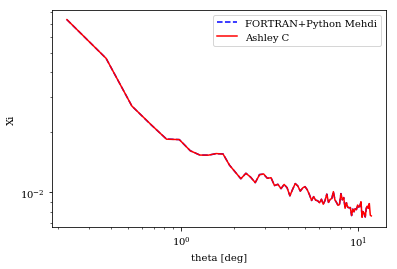

In [3]:
mask = weight > 0.2 # AJR
delta1 = makedelta(lrg, weight, np.ones_like(weight), mask)
Ta, Xia = np.loadtxt(path + 'xi_mehdiJul27/galDESILRGFalse2562ptPixclb.dat').T
# Ta.min(), Ta.max(), np.diff(Ta)[:3]
# (0.075, 11.925, array([-0.15, -0.15, -0.15]))

# RUN FORTRAN hp estimator
nside = 256
bin_i = 0.0
bin_f = 11.85
dbin  = 0.15
hpix = np.argwhere(mask).flatten()
theta, phi = hp.pix2ang(nside, hpix)
bins = np.deg2rad(np.arange(bin_i, bin_f, dbin))[::-1]
xi_hp = XI(theta, phi, theta, phi, delta1[mask], delta1[mask], weight[mask], weight[mask], bins, 1)


plt.plot(np.degrees(xi_hp[0][1:])+0.15/2, xi_hp[1][0]/xi_hp[1][1], 'b--', label='FORTRAN+Python Mehdi')
plt.plot(Ta, Xia, 'r-', label='Ashley C')
plt.loglog()
plt.xlabel('theta [deg]')
plt.ylabel('Xi')
_=plt.legend()